# 初始化

In [0]:
#@markdown - **挂载** 
from google.colab import drive
drive.mount('GoogleDrive')

In [0]:
# #@markdown - **卸载**
# !fusermount -u GoogleDrive

# 代码区

In [0]:
#@title 人脸识别 { display-mode: "both" }
# facial recognition
# 该程序通过 TensorFlow 搭建4层卷积神经网络实现对人脸数据集 FaceWarehouse 的分类
#@markdown 关于人脸库 [FaceWarehouse](http://kunzhou.net/zjugaps/facewarehouse/)
# 训练集、测试集图像与标签的数据存储于 data_path中的faces_150.mat
# 程序采用 L2 正则化解决过拟合问题
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import scipy.io as scio
import os,sys
from keras.utils import to_categorical

tf.logging.set_verbosity(tf.logging.ERROR)

Using TensorFlow backend.


In [0]:
#@markdown - **绑定数据**
class Bunch(dict):  
	def __init__(self,*args,**kwds):  
		super(Bunch,self).__init__(*args,**kwds)  
		self.__dict__ = self
        
#@markdown - **定义打印进度条函数**
def print_progress(progress, epoch_num, loss, acc):
    """
    This function draw an active progress bar.
    :param progress: Where we are:
                       type: float
                       value: [0,1]
    :param epoch_num: number of epochs for training
    :param loss: The loss for the specific batch in training phase.

    :return: Progressing bar
    """
    
    barLength = 30

    assert type(progress) is float, "id is not a float: %r" % id
    assert 0 <= progress <= 1, "variable should be between zero and one!"

    # 状态符号
    status = ""

    # 打印结束后返回 \r\n 换行
    if progress >= 1:
        progress = 1
        status = "\r\n"

    # 状态记录
    indicator = int(round(barLength*progress))

    list = [str(epoch_num), "#"*indicator , "-"*(barLength-indicator), progress*100, loss, acc, status]
    text = "\rEpoch {0[0]} {0[1]} {0[2]} {0[3]:.2f}% completed, loss={0[4]:.4f}, acc={0[5]:.2f}%{0[6]}".format(list)
    sys.stdout.write(text)
    sys.stdout.flush()

In [0]:
#@markdown - **定义初始化、卷积、池化函数**
def weight_variable(shape, name):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias_variable(shape, name):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial, name=name)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [0]:
#@markdown - **参数设置**
num_epochs = 400 #@param {type: "integer"}
batch_size = 128 #@param {type: "integer"}
decay_steps = 200 #@param {type: "number"}
keep_p = 0.5 #@param {type: "number"}
online_test = True #@param {type: "boolean"}

data_path = 'GoogleDrive/My Drive/MATLAB/face recognition/faces_database/faces_150.mat'
# data_path = 'GoogleDrive/My Drive/MATLAB/face recognition/faces_database/faces_150_equalhis.mat'

events_path = 'GoogleDrive/My Drive/Colab Notebooks/Tensorboard'
checkpoints_path = 'GoogleDrive/My Drive/Colab Notebooks/Checkpoints'

In [0]:
#@markdown - **参数设置**
data = scio.loadmat(data_path)
# -------------------训练集图像提取---------------------------------------------
train_image = data['train_faces']
train_labels = to_categorical(data['train_labels'].flatten(), num_classes=150)
train_data = Bunch(train_image=train_image, train_labels=train_labels)
print('\n', 'Train image set extraction completed... ...\n')

# ----------------测试集图像提取------------------------------------------------
test_image = data['test_faces']
test_labels = to_categorical(data['test_labels'].flatten(), num_classes=150)
test_data = Bunch(test_image=test_image, test_labels=test_labels)
print(' Test image set extraction completed... ...\n')


 Train image set extraction completed... ...

 Test image set extraction completed... ...



In [0]:
model_name = 'model.ckpt'
graph = tf.Graph()
with graph.as_default():
    global_step = tf.Variable(0, name='global_step', trainable=False)
    # decay_steps = 100
    decay_rate = 0.8
    start_rate = 1e-3 #@param {type: "number"}
    learning_rate = tf.train.exponential_decay(start_rate,
                                                global_step=global_step,
                                                decay_steps=decay_steps,
                                                decay_rate=decay_rate,
                                                staircase=True,
                                                name='exponential_decay')
    
    with tf.name_scope('Input'):
        x = tf.placeholder("float", shape=[None, 90, 75])
        y = tf.placeholder("float", shape=[None, 150])
        keep_prob = tf.placeholder("float") # keep_prob表示每个神经元被激活的概率
    with tf.name_scope('Input_images'):
        x_image = tf.reshape(x, [-1, 90, 75, 1])

# --------------conv1-----------------------------------45*38*32
    with tf.name_scope('Conv1'):
        with tf.name_scope('weights_conv1'):
            W_conv1 = weight_variable([3, 3, 1, 32], name='w_conv1')
        with tf.name_scope('bias_covn1'):
            b_conv1 = bias_variable([32], name='b_conv1')

        h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
        with tf.name_scope('features_conv1'):
            h_pool1 = max_pool_2x2(h_conv1)
# --------------conv2-----------------------------------23*19*64
    with tf.name_scope('Conv2'):
        with tf.name_scope('weights_conv2'):
            W_conv2 = weight_variable([3, 3, 32, 64], name='w_conv2')
        with tf.name_scope('bias_covn2'):
            b_conv2 = bias_variable([64], name='b_conv2')

        h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
        with tf.name_scope('features_conv2'):
            h_pool2 = max_pool_2x2(h_conv2)
# --------------conv3-----------------------------------12*10*128
    with tf.name_scope('Conv3'):
        W_conv3 = weight_variable([3, 3, 64, 128], name='w_conv3')
        b_conv3 = bias_variable([128], name='b_conv3')

        h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
        h_pool3 = max_pool_2x2(h_conv3)
# --------------conv4-----------------------------------6*5*256
    with tf.name_scope('Conv4'):
        W_conv4 = weight_variable([3, 3, 128, 256], name='w_conv4')
        b_conv4 = bias_variable([256], name='b_conv4')

        h_conv4 = tf.nn.relu(conv2d(h_pool3, W_conv4) + b_conv4)
        h_pool4 = max_pool_2x2(h_conv4)
# --------------conv5-----------------------------------3*3*512
    with tf.name_scope('Conv5'):
        W_conv5 = weight_variable([3, 3, 256, 512], name='w_conv5')
        b_conv5 = bias_variable([512], name='b_conv5')

        h_conv5 = tf.nn.relu(conv2d(h_pool4, W_conv5) + b_conv5)
        h_pool5 = max_pool_2x2(h_conv5)

# --------------fc--------------------------------------
    with tf.name_scope('FC1'):
        h_pool5_flat = tf.layers.flatten(h_pool5, name='pool5_flatten')
        num_f = h_pool5_flat.get_shape().as_list()[-1]
        W_fc1 = weight_variable([num_f, 1024], name='w_fc1')
        b_fc1 = bias_variable([1024], name='b_fc1')
        h_fc1 = tf.nn.relu(tf.matmul(h_pool5_flat, W_fc1) + b_fc1) # y=wx+b或者y.T=(x.T)(w.T)+b.T，其中y为列向量

    with tf.name_scope('Dropout1'):
        h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)
    
    with tf.name_scope('FC2'):
        W_fc2 = weight_variable([1024, 1024], name='w_fc2')
        b_fc2 = bias_variable([1024], name='b_fc2')
        h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
    with tf.name_scope('Dropout2'):
        h_fc2_drop = tf.nn.dropout(h_fc2, keep_prob)

    with tf.name_scope('OutPut_layer'):
        W_fc3 = weight_variable([1024, 150], name='w_fc3')
        b_fc3 = bias_variable([150], name='b_fc3')
        y_conv = tf.matmul(h_fc2_drop, W_fc3) + b_fc3

# ---------------------regularization_L2----------------
    tf.add_to_collection(tf.GraphKeys.WEIGHTS, W_fc1)
    tf.add_to_collection(tf.GraphKeys.WEIGHTS, W_fc2)
    # tf.add_to_collection(tf.GraphKeys.WEIGHTS, W_fc3)
    regularizer = tf.contrib.layers.l2_regularizer(scale=15./1500)
    reg_tem = tf.contrib.layers.apply_regularization(regularizer)
    
# ---------------------loss-----------------------------
    with tf.name_scope('Loss'):
        # y_conv = tf.nn.softmax(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)
        # cross_entropy = tf.reduce_mean(-y * tf.log(y_conv + 1e-10) + reg_tem) # 防止log0
    # or like
        cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,
                                        logits=y_conv) + reg_tem)

    with tf.name_scope('Train'):
        train_step = tf.train.AdamOptimizer(learning_rate).minimize(cross_entropy, global_step=global_step)
    # or like
    # with tf.name_scope('Train'):
    #     optimizer = tf.train.AdamOptimizer(learning_rate=2e-4)
    #     gradients_vars = optimizer.compute_gradients(cross_entropy)
    #     train_step = optimizer.apply_gradients(gradients_vars, global_step=global_step)
    with tf.name_scope('Accuracy'):
        correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [0]:
max_acc = 101.0
min_cross = 0.1
with tf.Session(graph=graph) as sess:
    saver = tf.train.Saver(var_list=tf.global_variables(), max_to_keep=3)
    sess.run(tf.global_variables_initializer())

    print('Training ========== (。・`ω´・) ========')
    for epoch_num in range(num_epochs):
        train_s = np.c_[train_data.train_image.reshape((1500,-1)), train_data.train_labels]
        np.random.shuffle(train_s)
        max_size = train_s.shape[0] // batch_size
        for num in range(max_size):
            batch = [train_s[num*batch_size:(num+1)*batch_size, :90*75].reshape((-1,90,75)), 
                    train_s[num*batch_size:(num+1)*batch_size, -150:]]
            _, acc, loss = sess.run([train_step, accuracy, cross_entropy], 
                                    feed_dict={x: batch[0], y: batch[1], keep_prob: keep_p})

            acc *= 100
            num_iter = max_size * 10
            progress = ((epoch_num * max_size + num) % num_iter + 1) / num_iter
            num_ep = epoch_num + 1
            print_progress(progress, num_ep, loss, acc)

        if online_test and (epoch_num + 1) % 10 ==0 :
            print(' '*12, 'Online-Testing ========== (。・`ω´・) ========')
            imgs_t, labels_t = test_data.test_image.reshape((-1, 90, 75)), test_data.test_labels
            test_acc, test_loss = sess.run([accuracy, cross_entropy], feed_dict={x: imgs_t, y: labels_t,
                                                                                keep_prob: 1.0})
            test_acc *= 100
            print(' '*10, 'Loss on testing data is %.4f, accuracy is %.2f%%.' %(test_loss, test_acc))
            print('\nKeep on training ========== (。・`ω´・) ========')

        # 保存精度高的3个模型(以acc和loss判断)
        if (loss <= min_cross) & (acc >= max_acc) & (epoch_num > 100): # step比tensorboard中数大1
            min_cross = loss
            max_acc = acc
            saver.save(sess, os.path.join(checkpoints_path, model_name), global_step=epoch_num)

    test_im, test_lab = train_data.train_image[0].reshape((-1, 90, 75)), train_data.train_labels[0].reshape((-1, 150))
    feature_map1 = sess.run(h_pool1, feed_dict={x: test_im, y: test_lab, keep_prob: 1.0})
#     feature_map2 = sess.run(h_pool2, feed_dict={x: test_im, y: test_lab, keep_prob: 1.0})

sess.close()
print('\n', 'Training completed.')

Training ========== (。・`ω´・) ========
Epoch 10 ##############################  100.00% completed, loss=118.8560, acc=0.78%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 118.3134, accuracy is 0.52%.

Keep on training ========== (。・`ω´・) ========
Epoch 20 ##############################  100.00% completed, loss=81.9438, acc=0.00%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 81.6646, accuracy is 2.90%.

Keep on training ========== (。・`ω´・) ========
Epoch 30 ##############################  100.00% completed, loss=63.8981, acc=5.47%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 63.5195, accuracy is 8.33%.

Keep on training ========== (。・`ω´・) ========
Epoch 40 ##############################  100.00% completed, loss=50.9215, acc=21.88%
             Online-Testing ========== (。・`ω´・) ========
           Loss on testing data is 49.9047, accuracy is 57.14%.



In [0]:
#@markdown - **复原保存的网络**
# with tf.Session() as sess:
    # model_path = 'Tensorboard/f_map.ckpt-241'
    # saver.restore(sess, model_path)
    # acc, loss = sess.run([accuracy, cross_entropy], feed_dict={x: test_data.test_image, 
                            # y: test_data.test_labels, keep_prob: 1.0})
    # acc_p = acc*100
    # print('Accuracy is %.2f' %(acc_p), '%.')
# sess.close()

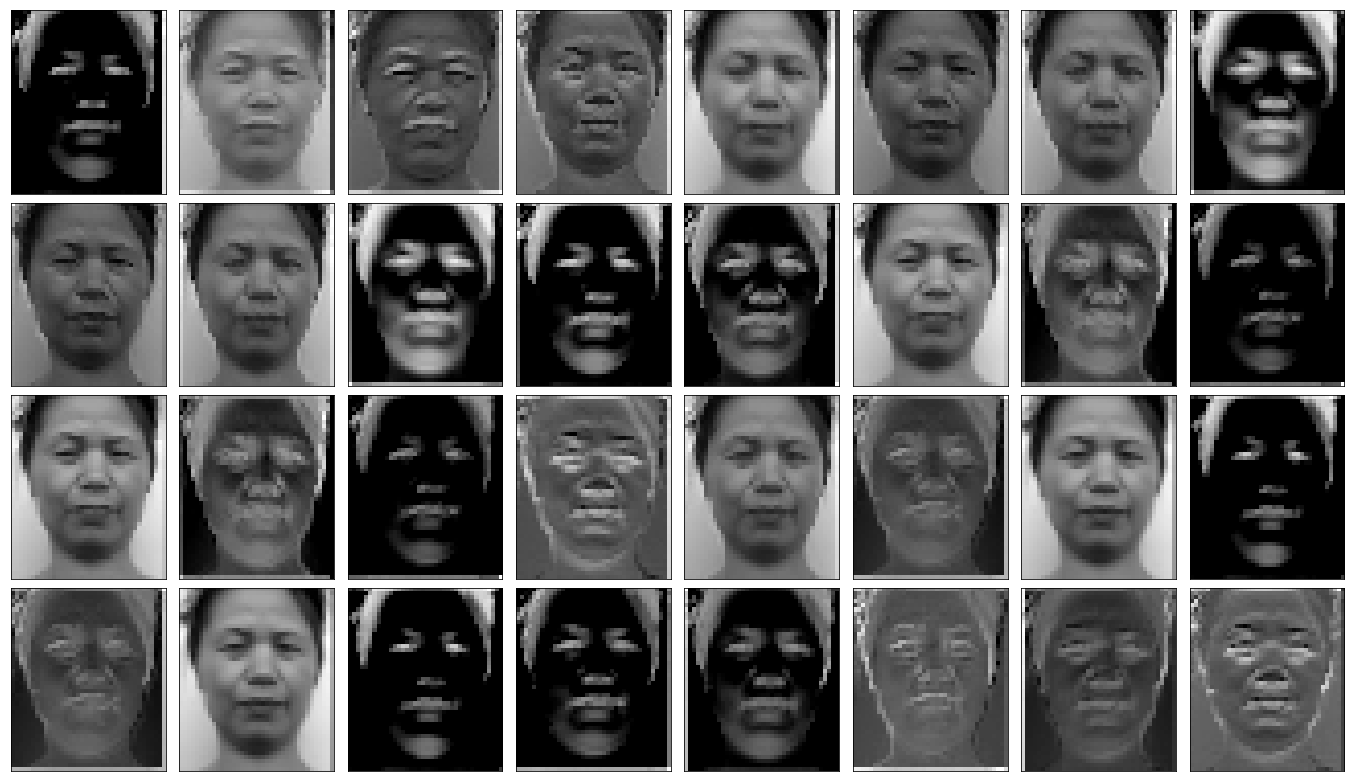

In [0]:
#@markdown - **第一个卷积层特征map**
f_map = feature_map1.reshape((45, 38, 32))
num_map = range(f_map.shape[-1])
fig = plt.figure(1,figsize=(24, 14))
G = gridspec.GridSpec(4, 8)
G.hspace,G.wspace = .05,.05
try:
    for i in range(4):
        for j in range(8):
            plt.subplot(G[i, j])
            num = i * 5 + j
            plt.imshow(f_map[:, :, num], 'gray')
            plt.xticks([]), plt.yticks([])
except IndexError:
    plt.xticks([]), plt.yticks([])
plt.show()